# COMP9418 - Assignment 1 - Bayesian Network, Naïve Bayes and TAN Bayes Classifiers

## UNSW Sydney, September 2022

- Stanley Zhou - z5255741


## Instructions

**Submission deadline:** Sunday, 16th October 2022, at 18:00:00 AEDT.

**Late Submission Policy:** The penalty is set at $5\%$ per late day for a maximum of 5 days. This is the UNSW standard late penalty. For example, if an assignment receives an on-time mark of 70/100 and is submitted three days late, it will receive a mark reduction of $70/100*15\%$. After five days, the assignment will receive a mark reduction of $100\%$.

**Form of Submission:** This is an **individual** or group of **two students** assignment. Write the name(s) and zID(s) in this Jupyter notebook. **If submitted in a group, only one member should submit the assignment. Also, create a group on WebCMS by clicking on Groups and Create and include both group members**.

You can reuse any piece of source code developed in the tutorials.

You can submit your solution via [WebCMS](https://webcms3.cse.unsw.edu.au/COMP9418/22T3).

Alternatively, you can submit your solution using give. On a CSE Linux machine, type the following on the command line:

``$ give cs9418 ass1 solution.zip``

## Technical prerequisites

These are the libraries you are allowed to use. No other libraries will be accepted. Make sure you are using Python 3.

In [1]:
# Allowed libraries
import numpy as np
import pandas as pd
import scipy as sp
import heapq as pq
import matplotlib as mp
import math
from itertools import product, combinations
from graphviz import Digraph
from tabulate import tabulate
import copy
from sklearn.model_selection import KFold
from datetime import datetime as dt

We can also use the python files we developed in tutorials or any other code from the tutorials.

In [2]:
from DiscreteFactors import Factor
from Graph import Graph
from BayesNet import BayesNet

## Task 0 - Initialise graph

Create a graph ``G`` that represents the following network by filling in the edge lists.
![Bayes Net](BayesNet.png)


In [3]:
G = Graph({
    "LymphNodes": [],
    'Metastasis': ["LymphNodes"],
    "BC": ["Metastasis","Mass","AD","NippleDischarge","SkinRetract","MC"],
    "Age": ["BC"],
    "Location": ["BC"],
    "MC": [],
    "SkinRetract": [],
    "NippleDischarge": [],
    "AD": ["FibrTissueDev"],
    "FibrTissueDev": ["NippleDischarge","SkinRetract","Spiculation"],
    "Spiculation": ["Margin"],
    "Margin": [],
    "Mass": ["Margin","Shape","Size"],
    "Shape": [],
    "Size": [],
    "BreastDensity": ["Mass"],
})

### Load data

In [4]:
# load data
with open('bc.csv') as file:
    data = pd.read_csv(file)

# remove 2 variables from data (because we are pretending we don't know this information)
if 'Metastasis' in data:
    del data['Metastasis']
if 'LymphNodes' in data:
    del data['LymphNodes']

# remove same 2 nodes from graph
G.remove_node('Metastasis')
G.remove_node('LymphNodes')

## [10 Marks] Task 1 - Efficient d-separation test

Implement the efficient version of the d-separation algorithm in a function ``d_separation(G, X, Z, Y)`` that return a boolean: ``True`` if **X** is d-separated from **Y** given **Z** in the graph $G$ and ``False`` otherwise.

* **X**,**Y** and **Z** are python sets, each containing a set of variable names. 
* Variable names may be strings or integers and can be assumed to be nodes of the graph $G$. 
* $G$ is a directed graph object as defined in tutorial 1.

In [5]:
def get_undirected_graph(g):
    
    g_prime = copy.deepcopy(g)
    keys = list(g.adj_list.keys())
    for key in keys:
        children = g.children(key)
        for child in children:
            g_prime.add_edge(child, key, directed=True)
    return g_prime

In [6]:
# Develop your code for d_separation(G, X, Z, Y) in this cell

def d_separation(G, X, Z, Y):
    '''
    Arguments:
        G:   is an object of type Graph (the class you developed in tutorial 1).
        X,Z and Y:  are python set objects.
    Returns:
        True if X is d-separared of Y given Z or False otherwise.
    '''
    g_prime = copy.deepcopy(G)

    while True:
        keys = list(set(g_prime.adj_list.keys()) - X - Y - Z)
        has_leaf = False
        for key in keys:
            if len(g_prime.children(key)) == 0:
                g_prime.remove_node(key)
                has_leaf = True
                break
        if not has_leaf:
            break

    for key in list(Z):
        children = g_prime.children(key)
        for child in children:
            g_prime.adj_list[key].remove(child)
    
    g_prime = get_undirected_graph(g_prime)
    g_prime.colour = {node: 'white' for node in g_prime.adj_list.keys()}
    
    for key in list(X):
        g_prime.dfs(key)
        
    for key in list(Y):
        if g_prime.colour[key] == 'white':
            return True
    return False

In [7]:
############
## TEST CODE
## Note: More hidden tests will be used. You should make more tests yourself.

def test(statement):
    if statement:
        print("Passed test case")
    else:
        print("Failed test case !!!")
        
test(d_separation(G, set(['Age']), set(['BC']), set(['AD'])))
test(not d_separation(G, set(['Spiculation', 'SkinRetract']), set(['MC', 'Size']), set(['Age'])))

Passed test case
Passed test case


## [5 Marks] Task 2 - Markov blanket

The Markov blanket for a variable $X$ is a set of variables that, when observed, will render every other variable irrelevant to $X$. If the distribution is induced by DAG $G$, then a Markov blanket for variable $X$ can be constructed using $X$'s parents, children, and spouses in $G$. A variable $Y$ is a spouse of $X$ if the two variables have a common child in $G$.

In this exercise, we will implement a function `Markov(G, X)` that returns a python set with the Markov blanket of $X$ in $G$ as described above.

In [8]:
# Develop your code for Markov_blanket(G, X) in this cell

def Markov_blanket(G, X):
    '''
    Arguments:
        G:   is an object of type Graph (the class you developed in tutorial 1)
        X:   is a node (variable) in G.
    Returns: 
        A python set with the Markov blanked of X in G
    '''
    g = copy.deepcopy(G)
    mb = set()
    
    # children
    mb = mb.union(set(g.children(X)))
    
    # parents
    g_t = g.transpose()
    mb = mb.union(set(g_t.children(X)))
    
    #spouses
    children = g.children(X)
    for child in children:
        mb = mb.union(set(g_t.children(child)))
    
    mb.remove(X)
    return mb


In [9]:
import copy
def Markov_blanket(G, X):
    '''
    Arguments:
        G:   is an object of type Graph (the class you developed in tutorial 1)
        X:   is a node (variable) in G.
    Returns: 
        A python set with the Markov blanked of X in G
    '''
    G = copy.deepcopy(G)
    Mb = set()
    
    Mb.update(G.children(X))
    GT = G.transpose() 
    Mb.update(GT.children(X))
    for Y in G.children(X):
        Mb.update(GT.children(Y))
    Mb.discard(X)
    return Mb

In [10]:
############
## TEST CODE
## Note: More hidden tests will be used. You should make more tests yourself.

def test(statement):
    if statement:
        print("Passed test case")
    else:
        print("Failed test case !!!")

test(Markov_blanket(G, 'Mass') == set(['Margin', 'Size', 'Shape', 'BreastDensity', 'BC', 'Spiculation']))
test(Markov_blanket(G, 'Age') == set(['Location', 'BC']))

Passed test case
Passed test case


In [11]:
######################
# Test code to copy  #
######################

test(Markov_blanket(G, 'BC') == set(['FibrTissueDev', 'NippleDischarge', 'MC', 'Age', 'Location', 'Mass', 'AD', 'BreastDensity', 'SkinRetract']))
test(Markov_blanket(G, 'Age') == set(['Location', 'BC']))
test(Markov_blanket(G, 'Location') == set(['Age', 'BC']))
test(Markov_blanket(G, 'MC') == set(['BC']))
test(Markov_blanket(G, 'SkinRetract') == set(['FibrTissueDev', 'BC']))
test(Markov_blanket(G, 'NippleDischarge') == set(['FibrTissueDev', 'BC']))
test(Markov_blanket(G, 'AD') == set(['FibrTissueDev', 'BC']))
test(Markov_blanket(G, 'FibrTissueDev') == set(['NippleDischarge', 'AD', 'BC', 'Spiculation', 'SkinRetract']))
test(Markov_blanket(G, 'Spiculation') == set(['Margin', 'FibrTissueDev', 'Mass']))
test(Markov_blanket(G, 'Margin') == set(['Spiculation', 'Mass']))
test(Markov_blanket(G, 'Mass') == set(['Margin', 'Size', 'Shape', 'BreastDensity', 'BC', 'Spiculation']))
test(Markov_blanket(G, 'Shape') == set(['Mass']))
test(Markov_blanket(G, 'Size') == set(['Mass']))
test(Markov_blanket(G, 'BreastDensity') == set(['Mass', 'BC']))

Passed test case
Passed test case
Passed test case
Passed test case
Passed test case
Passed test case
Passed test case
Passed test case
Passed test case
Passed test case
Passed test case
Passed test case
Passed test case
Passed test case


## Putting Tasks 1 and 2 together

This task is optional and will not be marked, but you can use it to test your code further. According to the Markov blanket definition: A Markov blanket for a variable $X \in \textbf{X}$ is the set of variables $\textbf{B} \subseteq \textbf{X}$ such that $X \notin \textbf{B}$ and $X \perp \textbf{X} \setminus (\textbf{B} \cup \{ X \}) | \textbf{B}$

In [12]:
# Develop your code to test your d-separation and Markov blanket implementations using the definition above.

set_X = {...}                                        # Set of all nodes in the graph
for X in set_X:
    mb = ...                                         # Markov_blanket of X
    ...                                              # Independence test according to the definition above

## [5 Marks] Task 3 - Learning the outcome space from data

Now, we will implement a series of functions to learn Bayesian network parameters from data. We will start by learning the outcome space of the variables in a Bayesian network. Remind from the tutorials that the outcome space is a python dictionary that maps the variable names to a tuple with the possible values this variable can have.

Implement a function ``learn_outcome_space(dataframe)`` that learns the outcome space (the valid values for each variable) from the pandas dataframe ``dataframe`` and returns a dictionary ``outcomeSpace`` with these values.

In [16]:
# Develop your code for learn_outcome_space(dataframe) in this cell

def learn_outcome_space(dataframe):
    '''
    Arguments:
        dataframe:    A pandas dataframe
    Returns: 
        outcomeSpace: A dictionary. e.g. {'A':('True', 'False'), 'B':('up','down','left'), 'C':(1,2,3,4)}
    '''
    outcome_space = {}
    for col in dataframe.columns:
        outcome_space[col] = tuple(set(dataframe[col]))
    
    return outcome_space

In [11]:
############
## TEST CODE
## Note: More hidden tests will be used. You should make more tests yourself.

outcomeSpace = learn_outcome_space(data)

outcomes = outcomeSpace['BreastDensity']
answer = ('high', 'medium', 'low')
test(len(outcomes) == len(answer) and set(outcomes) == set(answer))

Passed test case


## [5 Marks] Task 4 - Estimate Bayesian network parameters from data

Implement a method ``model.learn_parameters(dataframe, alpha=1)`` that learns the parameters of the Bayesian Network `model`. This function should do the same as the ``learn_parameters`` function from tutorials, but it should also implement laplacian smoothing with parameter $\alpha$.

In [21]:
def allEqualThisIndex(dict_of_arrays, **fixed_vars):

    # base index is a boolean vector, everywhere true
    first_array = dict_of_arrays[list(dict_of_arrays.keys())[0]]
    index = np.ones_like(first_array, dtype=np.bool_)
    for var_name, var_val in fixed_vars.items():
        index = index & (np.asarray(dict_of_arrays[var_name])==var_val)
    return index

def estimateFactor(data, var_name, parent_names, outcomeSpace, alpha):
    
    var_outcomes = outcomeSpace[var_name]
    parent_outcomes = [outcomeSpace[var] for var in (parent_names)]
    # cartesian product to generate a table of all possible outcomes
    all_parent_combinations = product(*parent_outcomes)

    f = Factor(list(parent_names)+[var_name], outcomeSpace)
    
    for i, parent_combination in enumerate(all_parent_combinations):
        parent_vars = dict(zip(parent_names, parent_combination))
        parent_index = allEqualThisIndex(data, **parent_vars)
        for var_outcome in var_outcomes:
            var_index = (np.asarray(data[var_name])==var_outcome)
            f[tuple(list(parent_combination)+[var_outcome])] = ((var_index & parent_index).sum() + alpha)/(parent_index.sum() + alpha * len(var_outcomes))
            
    return f

In [22]:
## Develop your code for learn_parameters(self, dataframe, alpha) in this cell

class BayesNet(BayesNet):
    def learn_parameters(self, dataframe, alpha=1):
        '''
        Arguments:
            data:    A pandas dataframe
            alpha:   Laplacian smoothing parameter
        '''        
        graphT = self.graph.transpose()
        for node, parents in graphT.adj_list.items():
            self.factors[node] = estimateFactor(data, node, parents, self.outcomeSpace, alpha)

In [23]:
############
## TEST CODE
## Note: More hidden tests will be used. You should make more tests yourself.

outcomeSpace = learn_outcome_space(data)
model = BayesNet(G, outcomeSpace=outcomeSpace)

model.learn_parameters(data, alpha=1)

print(model.factors['Age']['35-49'])
test(model.factors['Age']['35-49'] == 0.248000399920016)

0.248000399920016
Passed test case


In [24]:
temp = data[data['AD'] == 'No']
temp['FibrTissueDev'].value_counts() / temp.shape[0]

No     0.650421
Yes    0.349579
Name: FibrTissueDev, dtype: float64

In [25]:
print(model.factors['FibrTissueDev'])

╒══════╤═════════════════╤══════════╕
│ AD   │ FibrTissueDev   │       Pr │
╞══════╪═════════════════╪══════════╡
│ No   │ No              │ 0.650403 │
├──────┼─────────────────┼──────────┤
│ No   │ Yes             │ 0.349597 │
├──────┼─────────────────┼──────────┤
│ Yes  │ No              │ 0.256064 │
├──────┼─────────────────┼──────────┤
│ Yes  │ Yes             │ 0.743936 │
╘══════╧═════════════════╧══════════╛



## [5 Marks] Task 5 - Bayesian network classification

Design a new method ``model.predict(class_var, evidence)`` that implements the classification with complete data. This function should return the MPE value for the attribute `class_var` given the evidence. As we are working with complete data, `evidence` is an instantiation for all variables in the Bayesian network `model` but `class_var`.

**Implement the efficient classification procedure discussed in the lectures. Assure that you only join the necessary factors.**

In [26]:
## Develop your code for predict(self, class_var, evidence) in this cell

class BayesNet(BayesNet):
    
    def interactionGraph(self):
        
        g = Graph()
        for var in self.factors.keys():
            g.add_node(var) 
        for factor in self.factors.values():
            for var1 in factor.domain:
                for var2 in factor.domain:
                    if var1 != var2 and var1 not in g.children(var2):
                        g.add_edge(var1, var2, directed=False)
        return g
    
    def minDegree(self):
        ig = self.interactionGraph()
        order = [] 
        while len(ig) > 0:
            minDegree = math.inf
            for var in ig:
                if len(ig.children(var)) < minDegree:
                    minDegree = len(ig.children(var)) 
                    minVar = var 
            for var1, var2 in combinations(ig.children(minVar), 2):
                if var1 not in ig.children(var2):
                    ig.add_edge(var1, var2, directed=False)
            order.append(minVar) 
            ig.remove_node(minVar)             
        return order
    
    def VE(self, order):
        
        factorList = list(self.factors.values())
        for var in order:
            newFactor = Factor(tuple(), self.outcomeSpace)
            first = True
            updatedFactorsList = list()            

            for f in factorList:
                if var in f.domain:
                    newFactor = newFactor.join(f)
                    if not first: pass
                    first = False
                else:
                    updatedFactorsList.append(f)
                    
            newFactor = newFactor.marginalize(var) # TODO marginalize out `var`
            updatedFactorsList.append(newFactor)
            factorList = updatedFactorsList
        returnFactor = Factor(tuple(), self.outcomeSpace)
        for f in factorList:
            returnFactor = returnFactor*f
        return returnFactor

In [27]:
class BayesNet(BayesNet):
    def predict(self, class_var, evidence):
        '''
        Arguments:
            class_var:   Variable identifier to be classified
            evidence:    Python dictionary with one instantiation to all variables but class_var
        Returns:
            The MPE value (class label) of class_var given evidence
        '''        
        factors = copy.deepcopy(self.factors)
        blanket = Markov_blanket(self.graph, class_var)
        
        factor = self.factors[class_var]
        for b in blanket:
            factor = factor.join(self.factors[b])
            factor = factor.evidence(**evidence)
        
        index = np.argmax(factor.table)
        #print(factor.normalize())
        return self.outcomeSpace[class_var][index]
        

In [28]:
############
## TEST CODE
## Note: More hidden tests will be used. You should make more tests yourself.

outcomeSpace = learn_outcome_space(data)
model = BayesNet(G, outcomeSpace=outcomeSpace)
model.learn_parameters(data, alpha=1)

evidence = {'Age': '35-49', 
    'Location': 'LolwOutQuad', 
    'MC': 'No', 
    'SkinRetract': 'No', 
    'NippleDischarge': 'No',
    'AD': 'No',
    'FibrTissueDev': 'No', 
    'Spiculation': 'No',
    'Margin': 'Well-defined', 
    'Mass': 'No',
    'Shape': 'Other', 
    'Size': '<1cm',
    'BreastDensity': 'high'}

print(model.predict('BC', evidence))
test(model.predict('BC', evidence) == 'No')

No
Passed test case


In [29]:
######################
# Test code to copy  #
######################

evidence = data.iloc[42].to_dict()
del evidence['BC']
test(model.predict('BC', evidence) == 'No')

evidence = data.iloc[42].to_dict()
del evidence['AD']
test(model.predict('AD', evidence) == 'No')

evidence = data.iloc[42].to_dict()
del evidence['Size']
test(model.predict('Size', evidence) == '<1cm')

evidence = data.iloc[42].to_dict()
del evidence['Margin']
test(model.predict('Margin', evidence) == 'Well-defined')

evidence = data.iloc[42].to_dict()
del evidence['BreastDensity']
test(model.predict('BreastDensity', evidence) == 'medium')

Passed test case
Passed test case
Passed test case
Passed test case
Passed test case


## [5 Marks] Task 6 - Bayesian network accuracy estimation

Design a new function ``assess_bayes_net(model, dataframe, class_var)`` that uses the test cases in ``dataframe`` to assess the Bayesian network `model` performance at classifying the variable `class_var`. This function will return the accuracy of the Bayesian network according to the examples in ``dataframe``.

Remind that accuracy is the ratio of the number of correct predictions to the total number of cases.

In [30]:
## Develop your code for assess_bayes_net(model, dataframe, class_var) in this cell


def assess_bayes_net(model, dataframe, class_var='BC'):
    '''
    Arguments:
        model:     Bayesian Network object
        dataframe: a Pandas dataframe object
        class_var: Variable identifier to be classified
    Returns:
        The accuracy of the Bayesian network model in classifying the cases in dataframe
    '''     
    count, correct = 0, 0
    records = data.to_dict(orient='records')
    for row in records:
        # print(f'currently predicting: {count}')
        Y = row.pop(class_var)
        Y_hat = model.predict(class_var, row)
        
        if Y == Y_hat:
            correct += 1
        count += 1
    
    return correct/ count

In [31]:
def assess_bayes_net2(model, dataframe, var='BC'):
    '''
    Arguments:
        model:     Bayesian Network object
        dataframe: a Pandas dataframe object
        class_var: Variable identifier to be classified
    Returns:
        The accuracy of the Bayesian network model in classifying the cases in dataframe
    ''' 
    true_labels = dataframe[var]
    predictions = []
    
    for i, evidence in enumerate(dataframe.to_dict(orient='records')):
        del evidence[var]
        pred = model.predict(var, evidence)
        predictions.append(pred)
        
    acc = np.count_nonzero(true_labels == predictions)
    return acc, true_labels.shape[0]

In [32]:
print(assess_bayes_net(model, small_data, 'FibrTissueDev'))
print(assess_bayes_net_solution(model, small_data, 'FibrTissueDev'))

NameError: name 'small_data' is not defined

In [34]:

print(assess_bayes_net(model, small_data, 'Location'))
print(assess_bayes_net_solution(model, small_data, 'Location'))

(5645, 20000)
(571, (2000,))


In [35]:

print(assess_bayes_net(model, small_data, 'Size'))
print(assess_bayes_net_solution(model, small_data, 'Size'))

(17016, 20000)
(1708, (2000,))


In [27]:
print("If these tests break, try changing the \ndataset to full sized (and deduct 1 mark). Note that the tests are designed for the small dataset")
small_data = data.head(2000)

model = BayesNet(G, outcomeSpace)
model.learn_parameters(small_data, alpha=1)

acc = assess_bayes_net(model, small_data, 'BC')
test(abs(acc-0.84225) < 0.001)
acc = assess_bayes_net(model, small_data, 'FibrTissueDev')
test(abs(acc-0.8355) < 0.001)
acc = assess_bayes_net(model, small_data, 'Location')
test(abs(acc-0.294) < 0.001)
acc = assess_bayes_net(model, small_data, 'Size')
test(abs(acc-0.854) < 0.001)

print("Testing that unnecessary factors are not used")
# Confirm that they are not using the irrelevant "BreastDensity" table
# check that they are only using tables in the markov blanket, which are the tables of children and parents.
try:
    if "BreastDensity" in model.factors:
        del model.factors["BreastDensity"]
    assess_bayes_net(model, small_data, 'BC')
    print("Passed test case")
except:
    print("Failed test case")

If these tests break, try changing the 
dataset to full sized (and deduct 1 mark). Note that the tests are designed for the small dataset


KeyboardInterrupt: 

## [5 Marks] Task 7 - Bayesian network assessment with cross-validation

Implement a function called `cross_validation_bayes_net(G, dataframe, class_var, k)`, compute and report the average accuracy of the Bayesian network specified by the graph `G` over a $k=10$ cross-validation runs as well as the standard deviation. A scaffold for this function is provided below.

In [47]:
## Develop your code for cross_validation_bayes_net(G, dataframe, class_var, k) in this cell
# Answer

## Develop your code for assess_bayes_net(model, dataframe, class_var) in this cell

def assess_bayes_net(model, dataframe, var='BC'):
    '''
    Arguments:
        model:     Bayesian Network object
        dataframe: a Pandas dataframe object
        class_var: Variable identifier to be classified
    Returns:
        The accuracy of the Bayesian network model in classifying the cases in dataframe
    ''' 
    
    true_labels = dataframe[var]
    predictions = []
    
    for i, evidence in enumerate(dataframe.to_dict(orient='records')):
        del evidence[var]
        pred = model.predict(var, evidence)
        predictions.append(pred)
        
    acc = np.mean(true_labels == predictions)
    return acc


def cross_validation_bayes_net(G, dataframe, class_var='BC', k=10):
    '''
    Arguments:
        model:      Bayesian Network object
        dataframe:  a Pandas dataframe object
        class_var:  Variable identifier to be classified
        k:          number of cross-validation folds
    Returns:
        The mean accuracy and standand deviation of model across the k folds
    '''      
    accuracy_list = []
    
    kf = KFold(n_splits=k, shuffle = True, random_state = 42)
    for train, test in kf.split(dataframe):
      
        # train a model with learn_parameters
        model = BayesNet(G, outcomeSpace)
        model.learn_parameters(train, alpha=1)
        #print(type(train))
        # test the model with assess_bayes_net
        acc = assess_bayes_net(model, pd.DataFrame(test), class_var)
        
        accuracy_list.append(acc)
    return np.mean(accuracy_list), np.std(accuracy_list)

In [48]:
############
## TEST CODE

start = dt.now()
acc, stddev = cross_validation_bayes_net(G, data, 'BC', 10)
print(f'time taken = {dt.now() - start}')
test(abs(acc - 0.85) < 0.05)

KeyError: 'BC'

In [91]:
import time
s = time.time()
acc, stddev = cross_validation_bayes_net(G, data, 'BC')
print(f"Average accuracy: {acc} ± {stddev}")
e = time.time()
print("Time of cv_bayes_net", round(e-s,2))

######################
# Test code to copy  #
######################

import time
s = time.time()
acc, stddev = cross_validation_bayes_net(G, small_data, 'BC')
print(f"Average accuracy: {acc} ± {stddev}")
e = time.time()
print("Time of cv_bayes_net", round(e-s,2))
test(abs(acc-0.841) < 0.01)
test(abs(stddev - 0.02) < 0.015)
test(stddev > 0)
test(e-s < 5)
test(e-s < 10)
test(e-s < 30)




IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## [5 Marks] Task 8 - Naïve Bayes classifier structure

Let's work now with the Naïve Bayes classifier. This classifier is a Bayesian network with a pre-defined structure (graph). Let's start creating a new function, ``learn_naive_bayes_structure(dataframe, class_var)``, that learns the Naïve Bayes graph structure from a pandas `dataframe` using `class_var` as the class variable.

In [50]:
## Develop your code for learn_naive_bayes_structure(dataframe, class_var) in this cell

def learn_naive_bayes_structure(dataframe, class_var):
    '''
    Arguments:
        dataframe:   A pandas dataframe
        class_var:   Variable identifier to be classified
    Returns:
        A Graph object with the structure of the Naïve Bayes classifier for the attributes in dataframe
    '''
    cols = list(dataframe.columns)
    cols.remove(class_var)
    
    graph_dict = {}
    for col in cols:
        graph_dict[col] = []
    graph_dict[class_var] = cols
    
    g = Graph(graph_dict)
    
    return g

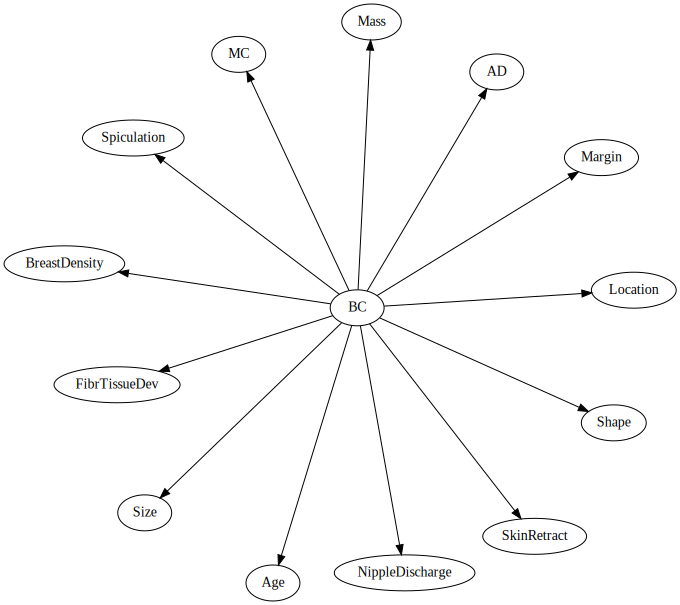

In [51]:
############
## TEST CODE

naiveG = learn_naive_bayes_structure(data, 'BC')
naiveG.show()

## [5 Marks] Task 9 - Naïve Bayes classification

As the Naïve Bayes classifier is a Bayesian network, we can use the existing `BayesNet` class to create a new class `NaiveBayes`.

Let's create a new method ``model.predict_log(class_var, evidence)`` that implements the classification with complete data. This function should return the MPE value for the attribute `class_var` given the `evidence`. As we work with complete data, `evidence` is an instantiation for all variables but `class_var`. **Use the log probability trick discussed in the lectures to classify each example**.

In [52]:
## Develop your code for predict_log(self, class_var, evidence) in this cell

class NaiveBayes(BayesNet):
    def predict_log(self, class_var, evidence):
        '''
        Arguments:
            class_var:   Variable identifier to be classified
            evidence:    Python dictionary with one instantiation to all variables but class_var
        Returns:
            The MPE value (class label) of class_var given evidence
        '''        
        result = Factor(self.factors[class_var].domain, self.factors[class_var].outcomeSpace)
        for outcome in self.factors[class_var].outcomeSpace[class_var]:
            result[outcome] += (np.log(self.factors[class_var][outcome]) - 1/3)
            
        
        for node, evi in evidence.items():
            for outcome in self.factors[class_var].outcomeSpace[class_var]:
                result[outcome] += np.log( self.factors[node][(outcome, evi)] )       
        
        index = np.argmax(result.table)
        return result.outcomeSpace[class_var][index]

In [53]:
############
## TEST CODE
## Note: More hidden tests will be used. You should make more tests yourself.

outcomeSpace = learn_outcome_space(data)
naiveG = learn_naive_bayes_structure(data, 'BC')
naive_model = NaiveBayes(naiveG, outcomeSpace=outcomeSpace)
naive_model.learn_parameters(data, alpha=1)
evidence = {'Age': '35-49', 
    'Location': 'LolwOutQuad', 
    'MC': 'No', 
    'SkinRetract': 'No', 
    'NippleDischarge': 'No',
    'AD': 'No',
    'FibrTissueDev': 'No', 
    'Spiculation': 'No',
    'Margin': 'Well-defined', 
    'Mass': 'No',
    'Shape': 'Other', 
    'Size': '<1cm',
    'BreastDensity': 'high'}

test(naive_model.predict_log('BC', evidence) == 'No')

Passed test case


In [54]:
outcomeSpace = learn_outcome_space(data)
naiveG = learn_naive_bayes_structure(data, 'BC')
naive_model = NaiveBayes(naiveG, outcomeSpace=outcomeSpace)
naive_model.learn_parameters(data, alpha=1)

evidence = data.iloc[42].to_dict()
del evidence['BC']
test(naive_model.predict_log('BC', evidence) == 'No')

evidence = data.iloc[42].to_dict()
del evidence['AD']
test(naive_model.predict_log('AD', evidence) == 'No')

evidence = data.iloc[42].to_dict()
del evidence['Size']
test(naive_model.predict_log('Size', evidence) == '<1cm')

evidence = data.iloc[42].to_dict()
del evidence['Margin']
test(naive_model.predict_log('Margin', evidence) == 'Well-defined')

evidence = data.iloc[42].to_dict()
del evidence['BreastDensity']
test(naive_model.predict_log('BreastDensity', evidence) == 'medium')

Passed test case


IndexError: tuple index out of range

## [5 Marks] Task 10 - Naïve Bayes accuracy estimation

Design a new function ``assess_naive_bayes(model, dataframe, class_var)`` that uses the test cases in ``dataframe`` to assess the performance of the Naïve Bayes classifier for the class variable `class_var`. This function will return the accuracy of the classifier according to the examples in the ``dataframe``.

In [65]:
## Develop your code for assess_naive_bayes(model, dataframe, class_var) in this cell

#model = NaiveBayes(...)
def assess_naive_bayes(model, dataframe, class_var='BC'):
    '''
    Arguments:
        model:      Naive Bayes object
        dataframe:  a Pandas dataframe object
        class_var:  Variable identifier to be classified
    Returns:
        The accuracy of the Naive Bayes model in classifying the cases in dataframe
    '''      
    count, correct = 0, 0
    records = dataframe.to_dict(orient='records')
    for row in records:
        # print(f'currently predicting: {count}')
        Y = row.pop(class_var)
        Y_hat = model.predict_log(class_var, row)
        
        if Y == Y_hat: correct += 1
        count += 1
    
    return correct / count

In [59]:
############
## TEST CODE
## Note: More hidden tests will be used. You should make more tests yourself.

naive_model = NaiveBayes(naiveG, outcomeSpace)
naive_model.learn_parameters(data, alpha=1)

acc = assess_naive_bayes(naive_model, data, 'BC')
test(abs(acc-0.7926) < 0.001)

Passed test case


In [61]:
######################
# Test code to copy  #
######################

### -------- Initialize model -----------
def true_learn_naive_bayes_structure(data, class_var):
    # create graph
    var_names = [key for key in data]
    graph = dict([(v,[]) for v in var_names])
    var_names.remove(class_var)
    for var in var_names:
        graph[class_var].append(var)
    return Graph(graph)

true_graph = true_learn_naive_bayes_structure(data, 'BC')
# ----------------------------------------

naiveG = learn_naive_bayes_structure(data, 'BC')

for v in true_graph:
    test(len(true_graph.adj_list[v]) == len(naiveG.adj_list[v]) and set(true_graph.adj_list[v]) == set(naiveG.adj_list[v]))

Passed test case
Passed test case
Passed test case
Passed test case
Passed test case
Passed test case
Passed test case
Passed test case
Passed test case
Passed test case
Passed test case
Passed test case
Passed test case
Passed test case


In [63]:
class NaiveBayes(BayesNet):
    def predict_log(self, class_var, evidence):
        '''
        Arguments:
            class_var:   Variable identifier to be classified
            evidence:    Python dictionary with one instantiation to all variables but class_var
        Returns:
            The MPE value (class label) of class_var given evidence
        '''          
        # get necessary factors
        relevant_factor_names = set(self.graph.children(class_var))
        relevant_factor_names.add(class_var)
        relevant_factors = dict((var, self.factors[var]) for var in relevant_factor_names)
        # add evidence to all factors
        for name in relevant_factors.keys():
            relevant_factors[name] = np.log(relevant_factors[name].evidence(**evidence).table)

        # join all factors
        f = np.zeros(len(self.outcomeSpace[class_var])) # trivial factor
        for fac in relevant_factors.values():
            f += fac
        
        # get row with maximum probability
        return self.outcomeSpace[class_var][np.argmax(f)]

In [66]:
print("If these tests break, try changing the \ndataset to full sized (and deduct 1 mark).\nNote that the tests are designed for the small dataset")
small_data = data.head(2000)

# Testing basic assess
true_graph = true_learn_naive_bayes_structure(small_data, 'BC')
naive_model = NaiveBayes(true_graph, outcomeSpace)
naive_model.learn_parameters(data)
acc = assess_naive_bayes(naive_model, small_data, 'BC')
test(abs(acc-0.7885) < 0.001)

true_graph = true_learn_naive_bayes_structure(small_data, 'FibrTissueDev')
naive_model = NaiveBayes(true_graph, outcomeSpace)
naive_model.learn_parameters(data)
acc = assess_naive_bayes(naive_model, small_data, 'FibrTissueDev')
test(abs(acc-0.7905) < 0.001)

true_graph = true_learn_naive_bayes_structure(small_data, 'Location')
naive_model = NaiveBayes(true_graph, outcomeSpace)
naive_model.learn_parameters(data)
acc = assess_naive_bayes(naive_model, small_data, 'Location')
test(abs(acc-0.267) < 0.001)

true_graph = true_learn_naive_bayes_structure(small_data, 'Age')
naive_model = NaiveBayes(true_graph, outcomeSpace)
naive_model.learn_parameters(data)
acc = assess_naive_bayes(naive_model, small_data, 'Age')
test(abs(acc-0.3815) < 0.001)

true_graph = true_learn_naive_bayes_structure(small_data, 'NippleDischarge')
naive_model = NaiveBayes(true_graph, outcomeSpace)
naive_model.learn_parameters(data)
acc = assess_naive_bayes(naive_model, small_data, 'NippleDischarge')
test(abs(acc-0.7525) < 0.001)

If these tests break, try changing the 
dataset to full sized (and deduct 1 mark).
Note that the tests are designed for the small dataset
Passed test case
Passed test case
Passed test case
Passed test case
Passed test case


## [5 Marks] Task 11 - Naïve Bayes assessment with cross-validation

Implement a function called `cross_validation_naive_bayes(dataframe, class_var, k)`, compute and report the average accuracy over the $k=10$-fold cross-validation runs as well as the standard deviation. A scaffold for this function is provided below.

In [68]:
## Develop your code for cross_validation_naive_bayes(dataframe, class_var, k) in this cell

def cross_validation_naive_bayes(dataframe, class_var='BC', k=10):
    accuracy_list = []
    
    kf = KFold(n_splits=k, shuffle = True, random_state = 42)
    for train, test in kf.split(dataframe):
      
        # train a model with learn_parameters
        model = NaiveBayes(naiveG, outcomeSpace)
        model.learn_parameters(train, alpha=1)
        
        # test the model with assess_bayes_net
        acc = assess_naive_bayes(model, test, class_var)
        
        accuracy_list.append(acc)
    return np.mean(accuracy_list), np.std(accuracy_list)   

In [280]:
############
## TEST CODE

start = dt.now()
acc, stddev = cross_validation_naive_bayes(data, 'BC')
print(f'time taken = {dt.now() - start}')
test(abs(acc - 0.80) < 0.05)

time taken = 0:00:59.532526
Passed test case


In [69]:
######################
# Test code to copy  #
######################

# Testing cross_validation
import time
s = time.time()
acc, stddev = cross_validation_naive_bayes(small_data, 'BC')
e = time.time()
print(f"Time of cv_naive_bayes: {e-s}")


# Testing efficiency
test(e-s < 5)
test(e-s < 7)
test(e-s < 12)
test(abs(acc-0.7885) < 0.01)
test(stddev > 0 and stddev < 0.04)

acc, stddev = cross_validation_naive_bayes(small_data, 'MC', 3)
test(abs(acc - 0.81) < 0.05)

acc, stddev = cross_validation_naive_bayes(small_data, 'Location', 8)
test(abs(acc - 0.26) < 0.03)

# Testing log probabilities
print("manually check that the student used log probabilities. Assign zero marks if not")

AttributeError: 'numpy.ndarray' object has no attribute 'to_dict'

## [15 Marks] Task 12 - Tree-augmented naïve Bayes structure

Let's work now with the Tree-augmented Naïve Bayes classifier. We will start creating a new function, ``learn_tan_structure(dataframe, class_var)``, that learns the Tree-augmented Bayes graph structure from a pandas dataframe.

In [281]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [66]:
def get_factor_by_node(node, dataframe, alpha=1):
    factor = Factor([node], learn_outcome_space(dataframe))
    marginal_p = (dataframe[node].value_counts() + alpha) / (dataframe[node].count() + alpha * dataframe[node].value_counts().shape[0])
    for outcome in marginal_p.index:
        factor.__setitem__(outcome, marginal_p[outcome])
    return factor

In [67]:
class Graph(Graph):
    
    def set_edge_weight(self, node1, node2, weight, undirected=True):
        self.edge_weights[(node1,node2)] = weight
        if undirected:
            self.edge_weights[(node2,node1)] = weight
    
    def prim_max(self, s):
        visited = [s]
        Q = []
        tree = Graph()
        for e in self.adj_list[s]:
            pq.heappush(Q, (-self.edge_weights[(s,e)], s, e))
        while len(Q) > 0:
            weight, v, u = pq.heappop(Q)
            if u not in visited:
                visited.append(u)
                tree.add_edge(v, u, -weight)
                for e in self.adj_list[u]:
                    if e not in visited:
                        pq.heappush(Q, (-self.edge_weights[(u,e)], u, e))        
        return tree

In [89]:
## Develop your code for learn_tan_structure(dataframe, class_var) in this cell

def learn_tan_structure(dataframe, class_var):
    '''
    Arguments:
        dataframe - A pandas dataframe
        class_var - Variable identifier to be classified
    Returns:
        A Graph object with the structure of the Naïve Bayes classifier for the attributes in dataframe and class_var
    '''
    nodes = list(dataframe.columns)
    nodes.remove(class_var)
    graph_dict = {}
    for node in nodes:
        neighbours = copy.deepcopy(nodes)
        neighbours.remove(node)
        graph_dict[node] = neighbours
    tan_graph = Graph(graph_dict)
    
    outcomeSpace = learn_outcome_space(dataframe)
    
    
    for idx1, var1 in enumerate(nodes):
        for idx2, var2 in enumerate(nodes):
            if var1 == var2: continue

            accum = 0
            for outcome_1 in outcomeSpace[var1]:
                for outcome_2 in outcomeSpace[var2]:
                    for outcome_bc in outcomeSpace[class_var]:
                        
                        class_var_count = dataframe[dataframe[class_var] == outcome_bc].shape[0]
                        joint = dataframe[(dataframe[var1] == outcome_1) & (dataframe[var2] == outcome_2) & (dataframe[class_var] == outcome_bc)]

                        tmp1 = joint.shape[0] / class_var_count
                        tmp2 = dataframe[(dataframe[var1] == outcome_1) & (dataframe[class_var] == outcome_bc)].shape[0] / class_var_count
                        tmp3 = dataframe[(dataframe[var2] == outcome_2) & (dataframe[class_var] == outcome_bc)].shape[0] / class_var_count
                        
                        if tmp1 == 0: continue
                        tmp = np.log2(tmp1) - np.log2(tmp2) - np.log2(tmp3)
                        tmp *= joint.shape[0] / data.shape[0]
                        accum += tmp
                        
            tan_graph.set_edge_weight(var1, var2, float(accum))
    
    max_tree = tan_graph.prim_max(nodes[0])
    for node in nodes:
        max_tree.add_edge(class_var, node)
        
    return max_tree

In [70]:
############
## TEST CODE

tan_graph = learn_tan_structure(data, class_var='BC')

test(len(tan_graph.children('BC')) == len(tan_graph)-1)
test('FibrTissueDev' in tan_graph.children('Spiculation') or 'Spiculation' in tan_graph.children('FibrTissueDev'))

Passed test case
Passed test case


In [90]:
######################
# Test code to copy  #
######################
import time

s = time.time()
tan_graph = learn_tan_structure(data.head(2000), 'BC')
e = time.time()

test(e-s < 5)
test(e-s < 15)

# Check that the graph has the correct number of edges
sum_edges = 0
for node, children in tan_graph.adj_list.items():
    if node != 'BC':
        sum_edges += len(children)
test(sum_edges == len(tan_graph)-2) #number of edges counted in the tree is num nodes in tree - 1 (which is nodes in graph-2 since BC doesn't count)

# Check that each node has at most 2 parents
GT = dict((v, []) for v in tan_graph)
for v in tan_graph:
    for w in tan_graph.children(v):
        GT[w].append(v)
less_than_two_parents = True
for node in GT:
    if(len(GT[node])>2):
        less_than_two_parents = False
test(less_than_two_parents)

print("Testing structure learning on lecture dataset")

# lecture dataset
data2 = {}
data2['A1'] = [1,1,1,0,1,1,1,0,0,1]
data2['A2'] = [1,0,0,1,1,0,1,0,1,1]
data2['A3'] = [0,1,1,1,1,1,0,0,1,1]
data2['A4'] = [1,1,1,1,0,1,0,1,1,0]
data2['C']  = [0,1,1,1,0,1,0,0,1,0]
outcomeSpace2 = {
    'A1':(0,1),
    'A2':(0,1),
    'A3':(0,1),
    'A4':(0,1),
    'C':(0,1),
    }
data2 = pd.DataFrame.from_dict(data2)
graph2 = learn_tan_structure(data2, 'C')
graph2.show()
test('A2' in graph2.children('A1') or 'A1' in graph2.children('A2'))
test('A4' in graph2.children('A2') or 'A2' in graph2.children('A4') or 'A4' in graph2.children('A1') or 'A1' in graph2.children('A4'))
test('A3' in graph2.children('A4') or 'A4' in graph2.children('A3'))

Failed test case !!!
Passed test case
Passed test case
Passed test case
Testing structure learning on lecture dataset
Passed test case
Passed test case
Passed test case


## [5 Marks] Task 13 - Tree-augmented naïve Bayes assessment with cross-validation

Implement a function called `cross_validation_tan(dataframe, class_var, k)`, compute and report the average accuracy over the $k=10$-fold cross-validation runs and the standard deviation. A scaffold for this function is provided below.

In [286]:
def assess_tan(model, dataframe, class_var='BC'):
    '''
    Arguments:
        model:     Bayesian Network object
        dataframe: a Pandas dataframe object
        class_var: Variable identifier to be classified
    Returns:
        The accuracy of the Bayesian network model in classifying the cases in dataframe
    '''     
    count, correct = 0, 0
    records = data.to_dict(orient='records')
    for row in records:
        #print(f'currently predicting: {count}')
        Y = row.pop(class_var)
        Y_hat = model.predict(class_var, row)
        
        if Y == Y_hat:
            correct += 1
        count += 1
    
    return correct / count

outcomeSpace = learn_outcome_space(data)
tan_graph = learn_tan_structure(data, class_var='BC')
model = BayesNet(tan_graph, outcomeSpace=outcomeSpace)

model.learn_parameters(data, alpha=1)
assess_tan(model, data)

0.83425

In [287]:
## Develop your code for cross_validation_tan(dataframe, class_var, k) in this cell

def cross_validation_tan(dataframe, class_var='BC', k=10):
    accuracy_list = []
    
    kf = KFold(n_splits=k, shuffle = True, random_state = 42)
    for train, test in kf.split(dataframe):
      
        # train a model with learn_parameters
        model = BayesNet(tan_graph, outcomeSpace)
        model.learn_parameters(train, alpha=1)
        
        # test the model with assess_bayes_net
        acc = assess_tan(model, test, class_var)
        
        accuracy_list.append(acc)
    return np.mean(accuracy_list), np.std(accuracy_list)   

In [288]:
############
## TEST CODE

start = dt.now()
acc, stddev = cross_validation_tan(data, 'BC')
print(f'time taken = {dt.now() - start}')
test(abs(acc - 0.83) < 0.05)

time taken = 0:08:45.316942
Passed test case


## [20 Marks] Task 14 - Report

Write a report (**with less than 500 words**) summarising your findings in this assignment. Your report should address the following:

a. Make a summary and discussion of the experimental results. You can analyse your results from different aspects such as accuracy, runtime, coding complexity and independence assumptions. You can use plots to illustrate your results.

b. Discuss the time and memory complexity of the implemented algorithms.

Use Markdown and Latex to write your report in the Jupyter notebook. Develop some plots using Matplotlib to illustrate your results. Be mindful of the maximum number of words. Please, be concise and objective.

---
The Bayesian network has the highest accuracy at around 85%, the TAN has the seccond highest accuracy at 83%, and Naive Bayes has the lowest at 80%. 

The Naive Bayes has low accuracy partly from its independence assumptions, it assumes that all features are independent conditioned on the class variable (BC), which is not true. For the Bayesian network, the independence assumption is given by the graph's structure and Markovian assumption. The TAN has no independence assumption among variables to construct the tree structure, it uses largest conditional Mutual Information to construct the max spanning tree.

Naive Bayes is the easiest to code, it is a tree with the class variable as the root and all other variables as leaves. Bayesian network is second easiest to code, however, it requires domain knowledge to produce the DAG. The TAN is the most complex to code and implement, it requires computing pairwise Mutual Information, producing a max spanning tree and obtain the graph structure. 

The runtime also reflects the ease of coding and algorithm complexity. Using the same data and 10 fold cross-validation, Naive Bayes takes the shortest to run (0:59), Bayesian network is second shortest (5:28), and TAN takes the longest (8:45), as producing TAN requires much more steps than the others. 

Naive Bayes: time complexity is O(n * c) where n is the number of independent variables and c is the number of classes; space complexity is O(n * c) too, as there are n conditional probability tables, each with c entries representing different class values.

Bayesian network: time complexity is O(n * c) where n is the number of independent variables and c is the number of classes; for each CPT, if the max number of parents for each variable is k, then the size of each CPT is O(c^(k+1)), given there are n variables, the space complexity is O(n * c^(k+1))

TAN: time complexity for computing network structure is O(n * n * c) where n is the number of independent variables and c is the number of classes, time complexity for making prediction is O(n * c); the space complexity for computing network structure is O(n * d), where d is the number of entries on the data table, i.e. it takes the entire table in memory. the space complexity for storing CPT is O(n * c^(k+1)), same reasoning as the above.

---